In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib; matplotlib.use('TkAgg')
import torch
import kornia as K
import sys
%matplotlib inline

In [2]:

def imageRead(fileName):
    img = cv2.imread(fileName)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    return img

def img2tensor(img):
    img = torch.from_numpy(img)
    img = img.permute(2,0,1)
    img = img.unsqueeze(0)
    img = img.float()
    # No grayscaling this time    
    img = img
    return img

# This is different too because of rgb channels
def tensor2img(tensor):
    img = tensor.squeeze(0)
    img = img.permute(1,2,0)    
    img = img.detach().numpy()    
    return img

def resizeLongEdge(img, longEdge=512):
    h, w, c = img.shape
    if h > w:
        h_new = longEdge
        w_new = int(w * h_new / h)
    else:
        w_new = longEdge
        h_new = int(h * w_new / w)
    img = cv2.resize(img, (w_new, h_new))
    return img

In [3]:
def getEnergy(img):
    dualGrads= K.filters.spatial_gradient(img)
    E = torch.sqrt(dualGrads[0,0, 0, :, :]**2 + dualGrads[0,0, 1, :, :]**2)
    min_val = torch.min(E)
    max_val = torch.max(E)
    normalized_E = (E - min_val) / (max_val - min_val)
    return normalized_E
    


def CarveHelper(tensor):
    E = getEnergy(tensor)
    M = torch.zeros_like(E)
    # Set first row to match the energy
    
    M[0,:]=E[0,:]
    for row in range(1,M.shape[0]):
        M[row, 0] = E[row, 0] + min(M[row-1, 0], M[row-1, 1])
        # For the last column
        lastCol = M.shape[1] - 1
        M[row, lastCol] = E[row, lastCol] + min(M[row-1, lastCol-1], M[row-1, lastCol])
        for col in range(1,M.shape[1]):
            M[row,col]=E[row,col]+torch.min(M[row-1,col-1:col+1])        
    #Back-propogation
    # print(M)
    C, H, W = tensor.shape[1:]
    seamIndices = torch.zeros(H).view(-1,1)
    seamIndices-=1  # Set em to -1 so 0 indices don't get removed
    newImg = torch.zeros(C,H,W-1)
    lastIndex = torch.argmin(M[-1, :])  # Start from the last row
    for revRow in range(H - 2, -1, -1):
        row = tensor[0, :, revRow, :]  # This should have shape [C, W]    
        left = max(0, lastIndex - 1)
        right = min(W - 1, lastIndex + 1)
        
        # Find the minimum in the connected neighborhood
        index = left + torch.argmin(M[revRow, left:right + 1])       
        # Create a new row by excluding the column at the index
        newRow = torch.cat((row[:, :index], row[:, index + 1:]), dim=1)
        # Update the new image
        
        newImg[:, revRow, :] = newRow
        lastIndex = index
    
    newImg = newImg.unsqueeze(0)
    return newImg

def CarveHelperFast(tensor, step):
    C, H, W = tensor.shape[1:]
    newImg = torch.zeros(C, H, W - step)
    E = getEnergy(tensor)
    M = torch.zeros_like(E)
    M[0, :] = E[0, :]
    for row in range(1, M.shape[0]):
        M[row, 0] = E[row, 0] + min(M[row - 1, 0], M[row - 1, 1])
        # For the last column
        lastCol = M.shape[1] - 1
        M[row, lastCol] = E[row, lastCol] + min(M[row - 1, lastCol - 1], M[row - 1, lastCol])
        for col in range(1, M.shape[1]):
            M[row, col] = E[row, col] + torch.min(M[row - 1, col - 1:col + 1])
    for _ in range(step):
        C, H, W = tensor.shape[1:]
        newImg = torch.zeros(C, H, W - 1)
        newM = torch.zeros(H, W - 1)        
        seamIndices = torch.zeros(H).view(-1, 1)
        seamIndices -= 1  # Set em to -1 so 0 indices don't get removed       
        lastIndex = torch.argmin(M[-1, :])  # Start from the last row 
        for revRow in range(H -1, -1, -1):
            row = tensor[0, :, revRow, :]  # This should have shape [C, W]
            left = max(0, lastIndex - 1)
            right = min(W - 1, lastIndex + 1)            
            # Find the minimum in the connected neighborhood
            index = left + torch.argmin(M[revRow, left:right + 1])            
            newRow = torch.cat((row[:, :index], row[:, index + 1:]), dim=1)
            newMRow = torch.cat((M[revRow, :index], M[revRow, index + 1:]), dim=0)
            # print("NewRow Shape: ",newRow.shape)
            # print("NewImg Shape: ",newImg.shape)
            newImg[:, revRow, :] = newRow
            newM[revRow, :] = newMRow
            lastIndex = index
            # Update M and E to exclude the seam
        M = newM
        tensor = newImg.unsqueeze(0)
    return tensor

def MySeamCarving(imgTensor, w,h):
    # Carve the image to the desired size
    if(imgTensor.shape[2] < h):
        print(imgTensor.shape[2])
        raise ValueError("Height ",imgTensor.shape[2], "too small")
    if(imgTensor.shape[3] < w):
        raise ValueError("Width too small")        
    heightToCarve = imgTensor.shape[2] - h
    widthToCarve = imgTensor.shape[3] - w
    print("Height to carve: ",heightToCarve," Width to carve: ",widthToCarve)
    totalToCarve = heightToCarve + widthToCarve
    progress = 0
    for i in range(widthToCarve):
        imgTensor = CarveHelper(imgTensor)
        progress += 1
        prog = progress/totalToCarve*100
        sys.stdout.write("\rProgress: %d%%" % prog)
        sys.stdout.flush()
        # print("Progress: ",progress/totalToCarve*100,"%")
    # imgTensor = torch.rot90(imgTensor, 1, [2, 3])
    imgTensor = imgTensor.permute(0, 1, 3, 2)
    for i in range(heightToCarve):
        imgTensor = CarveHelper(imgTensor)
        progress += 1
        prog = progress/totalToCarve*100
        sys.stdout.write("\rProgress: %d%%" % prog)
        sys.stdout.flush()
    imgTensor = imgTensor.permute(0, 1, 3, 2)
    # imgTensor = torch.rot90(imgTensor, -1, [2, 3])
    return imgTensor

def MySeamCarving2(imgTensor, w, h, batch_size=10):
    if imgTensor.shape[2] < h:
        print(imgTensor.shape[2])
        raise ValueError("Height too small")
    if imgTensor.shape[3] < w:
        raise ValueError("Width too small")
    
    heightToCarve = imgTensor.shape[2] - h
    widthToCarve = imgTensor.shape[3] - w
    
    print(f"Height to carve: {heightToCarve}, Width to carve: {widthToCarve}")
    
    totalToCarve = heightToCarve + widthToCarve
    progress = 0
    sys.stdout.write("\rProgress: %d%%" % progress)
    # Carving width
    for i in range(0, widthToCarve, batch_size):
        n_steps = min(batch_size, widthToCarve - i)
        imgTensor = CarveHelperFast(imgTensor, step=n_steps)
        progress += n_steps
        prog = (progress / totalToCarve) * 100
        sys.stdout.write("\rProgress: %d%%" % prog)
        sys.stdout.flush()
    
    # Carving height (after transposing the image)
    imgTensor = imgTensor.permute(0, 1, 3, 2)
    for i in range(0, heightToCarve, batch_size):
        n_steps = min(batch_size, heightToCarve - i)
        imgTensor = CarveHelperFast(imgTensor, step=n_steps)
        progress += n_steps
        prog = (progress / totalToCarve) * 100
        sys.stdout.write("\rProgress: %d%%" % prog)
        sys.stdout.flush()
    print()
    imgTensor = imgTensor.permute(0, 1, 3, 2)
    return imgTensor



torch.Size([1, 3, 1151, 1728])
Height to carve: 431, Width to carve: 0
Progress: 100%
(720, 1728, 3)


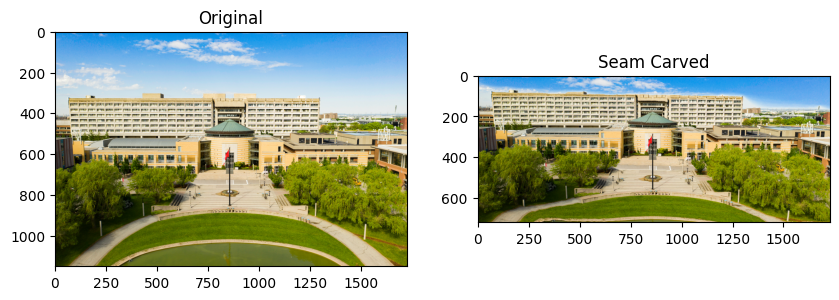

In [6]:
def SaveImgFn():
    images = ["../Media/castle.jpg","../Media/York.jpg"]
    # castleConfig = [512, 400, 300]
    # 512 X 347
    # yorkConfig = [512, 400, 300]
    # 512 X 341
    currImg = 1
    img = imageRead(images[currImg])
    # img = resizeLongEdge(img,512)
    tensor = img2tensor(img)
    print(tensor.shape)

    newTensor = MySeamCarving2(tensor, 1728, 720,1)
    newImg = tensor2img(newTensor)
    print(newImg.shape)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(tensor2img(tensor))
    plt.subplot(1,2,2)
    plt.title("Seam Carved")
    plt.imshow(newImg)
    plt.imsave(images[currImg]+"_CarvedYFR.jpg", newImg)    